In [103]:
from prysm import geometry, coordinates, polynomials, detector
from prysm.propagation import Wavefront as WF
from prysm.segmented import _local_window
import numpy as np
from math import ceil
import matplotlib.pyplot as plt
from astropy.io import fits
import cv2 as cv
import scipy.ndimage

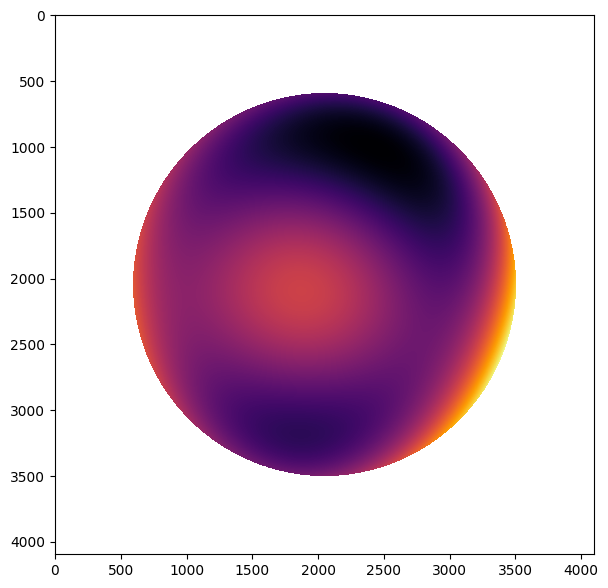

In [104]:
x, y = coordinates.make_xy_grid(4096, diameter=14) #14mm 'diameter', aiming to be imaged by an imx533 11.31mm x 11.31mm square sensor
r, t = coordinates.cart_to_polar(x, y)
dx = x[0,1]-x[0,0]

#optical system paramters, a 5mm wavefront radius at 650nm
rmax = 5
wvl = 0.650

amp = geometry.circle(rmax, r)

#add a whole bunch of abberations
phs = polynomials.zernike_nm(4,0, r/rmax, t) # Zernike flavor spherical aberration
phs += (polynomials.zernike_nm(2,2, r/rmax, t)) # Zernike flavor astig
phs += (polynomials.zernike_nm(2,-2, r/rmax, t))/2 # Zernike flavor astig
phs += ((polynomials.zernike_nm(1,-1, r/rmax, t))/3) # Zernike flavor tilt in y
phs += ((polynomials.zernike_nm(1,-1, r/rmax, t))/3) # Zernike flavor tilt in y

phs += ((polynomials.zernike_nm(3,1, r/rmax, t))/2) # Coma
phs += ((polynomials.zernike_nm(3,-3, r/rmax, t))/4) # Trefoil




nwaves_aber = 5
phs = phs * (wvl*1e3 * nwaves_aber)

#plot the wavefront phase at points where the aperture hasn't stopped it
phi2 = phs.copy()
phi2[amp!=1]=np.nan
plt.figure(figsize=(7,7))

#plt.colorbar(phi2)
plt.imshow(phi2, cmap='inferno')

plt.show()

wf = WF.from_amp_and_phase(amp, phs, wvl, dx)

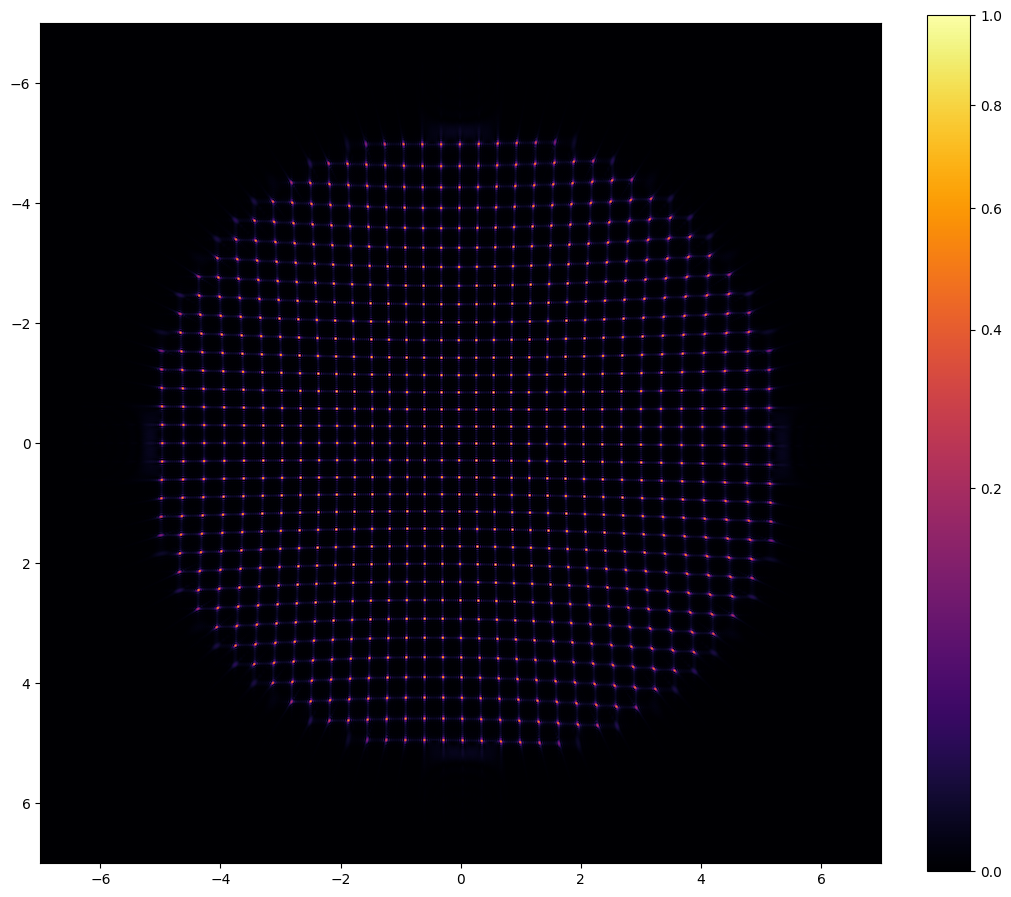

In [105]:
def shack_hartmann_phase_screen(x, y, pitch, n, efl, wavelength, aperture=geometry.rectangle):
    if not hasattr(n, '__iter__'):
        n = (n,n)

    dx = x[0,1] - x[0,0]
    samples_per_lenslet = int(pitch / dx + 1) # ensure safe rounding

    xc, yc = coordinates.make_xy_grid(n, dx=pitch, grid=False)
# if you use prysm's plotting utilities, they shear things a bit to be "FFT aligned"
# and doing this will make the center of the beam not contain a lenslet
# uncomment this if you want symmetric lenslets across the origin, instead
# of having a lenslet at the origin

#     if not is_odd(n[0]):
#         # even number of lenslets, FFT-aligned make_xy_grid needs positive shift
#         xc += (pitch/2)
#     if not is_odd(n[1]):
#         yc += (pitch/2)

    cx = ceil(x.shape[1]/2)
    cy = ceil(y.shape[0]/2)
    lenslet_rsq = (pitch/2)**2
    total_phase = np.zeros_like(x)
    for j, yy in enumerate(yc):
        for i, xx in enumerate(xc):
            iy, ix = _local_window(cy, cx, (xx,yy), dx, samples_per_lenslet, x, y)
            lx = x[iy, ix] - xx
            ly = y[iy, ix] - yy
            rsq = lx * lx + ly * ly
            phase = rsq / (2*efl)
            phase *= aperture(pitch/2, lx, ly)
# swap the aperture here if you fancy
#             phase *= geometry.circle(lenslet_rsq, rsq)
            total_phase[iy, ix] += phase

    prefix = -1j * 2 * np.pi/(wavelength/1e3)
    return np.exp(prefix*total_phase)


# above this is your "library" code

# diameter here is the beam in mm, need to assume some sort of magnification between your telescope
# and the SH-WFS
#
# also, if you fiddle with the SH-WFS lenslet parameters, they are quite sensitive and easy to drive the model
# into an undersampled regime (need more samples)
# or have the lenslet PSFs overlap because the F/# is so big.  Delicate balancing act.



efl = 14.6
mask = shack_hartmann_phase_screen(x, y, pitch=.3, n=33, efl=efl, wavelength=wvl)
wf = wf * mask
wf2 = wf.free_space(dz=efl, Q=1)
i = wf2.intensity
i.data /= i.data.max()

hdu = fits.PrimaryHDU(i.data)
hdu.writeto('prysm_sh_capture.fits', overwrite=True)
fig, ax = plt.subplots(figsize=(12,12))
i.plot2d(power=1/2,  interpolation='lanczos',  fig=fig, ax=ax)
plt.show()

Image min: 792 and max: 1332


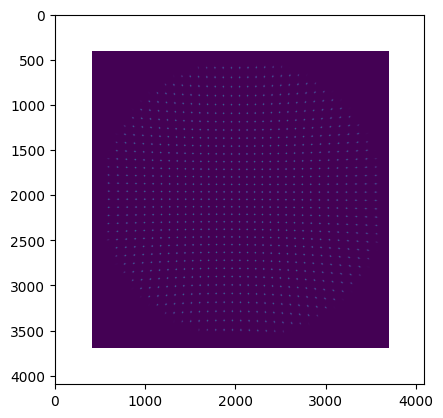

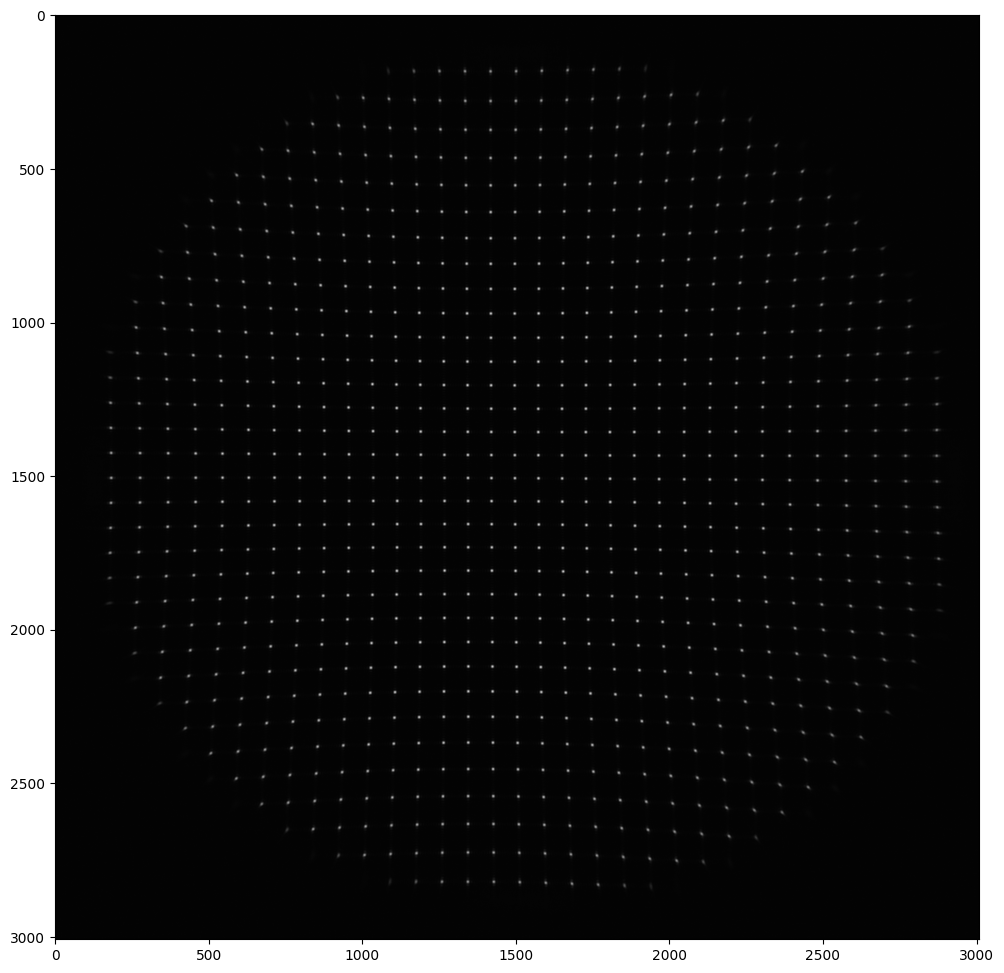

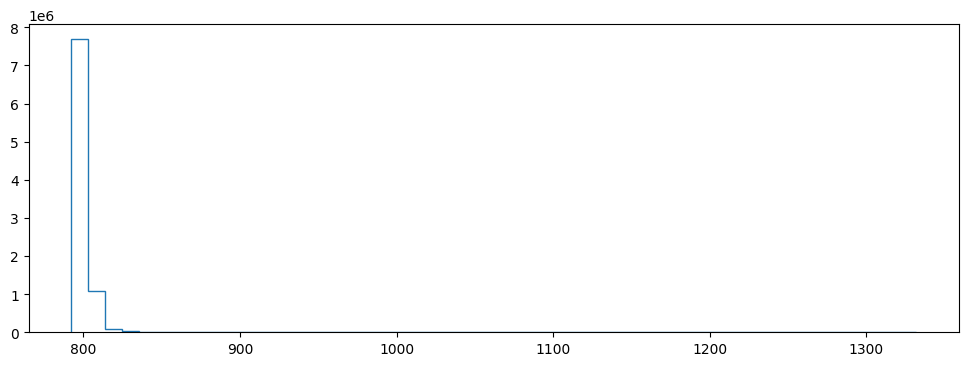

In [106]:
peak_eminus = 100 #intensity of light 

#sensor parameters - notionally an imx533 at 25C
dark_current = 0.06250
fwc = 50_000
rn = 1.5
bias = 800
kgain = 1
bit_depth = 14
texp = 5 #1 sec
cam = detector.Detector(dark_current, rn, bias, fwc, kgain, bit_depth, texp)

#now we need to take the area the the sensor will observe out of the simulation coordinate space and convert to pixels
sensor_width = 11.31
sensor_height = sensor_width

sensor_area_x = (sensor_width/2  >= x) & (-1*sensor_width/2  <= x)
sensor_area_y = (sensor_height/2 >= y) & (-1*sensor_height/2  <= y)
sensor_area = sensor_area_x & sensor_area_y
i_sens = i.data.copy()
i_sens[sensor_area!=True]=np.nan 
plt.imshow(i_sens)

#now actually grab the relevant sensor indicies out of the full simulation xy space
sensor_field_indicies = np.where(sensor_area == True)
sensor_field = i.data[sensor_field_indicies[0][0]:sensor_field_indicies[0][-1],sensor_field_indicies[1][0]:sensor_field_indicies[1][-1]]

#resample to the simulation plane to pixels
sensor_width_npx = 3008
sensor_height_npx = sensor_width_npx
img2 = cv.resize(sensor_field, dsize=(sensor_height_npx, sensor_width_npx))

sh_capture = cam.expose(img2*peak_eminus)
plt.figure(figsize=(12,12))
plt.imshow(sh_capture, cmap='gray')


#some stats from the image to check exposure
print(f"Image min: {np.min(sh_capture)} and max: {np.max(sh_capture)}")
plt.figure(figsize=(12,4))
counts, bins = np.histogram(sh_capture, bins=50)
plt.stairs( counts, bins)

In [107]:
#assuming 0,0 is top left....
#never converting back from pixels to world space :)
def optical_coords_to_pixel(x,y,sensor_x_pitch, sensor_y_pitch, sensor_x_px_count, sensor_y_px_count):
    xpx = x /sensor_x_pitch
    ypx = y /sensor_y_pitch
    centre_offset_x = sensor_x_px_count / 2
    centre_offset_y = sensor_y_px_count / 2
    return (xpx+centre_offset_x, centre_offset_y-ypx)

def cartesian_grad_to_polar_grad(x, y, dx, dy):
    r, t = coordinates.cart_to_polar(x, y, vec_to_grid=False)
    grad_end_pts_x = x + dx 
    grad_end_pts_y = y + dy 
    grad_end_pts_r, grad_end_pts_t = coordinates.cart_to_polar(grad_end_pts_x, grad_end_pts_y, vec_to_grid=False)

    dr = r - grad_end_pts_r
    dt = t - grad_end_pts_t
    
    dt = (dt + np.pi) % (2 * np.pi) - np.pi
    return dr, dt

def polar_gradient_to_cartesian_grad(r, t, dr, dt):
    x, y = coordinates.polar_to_cart(r, t)
    grad_end_pts_r = r + dr
    grad_end_pts_t = t + dt 
    grad_end_pts_x, grad_end_pts_y = coordinates.polar_to_cart(grad_end_pts_r, grad_end_pts_t)

    dx = x - grad_end_pts_x
    dy = y - grad_end_pts_y
    return dx, dy

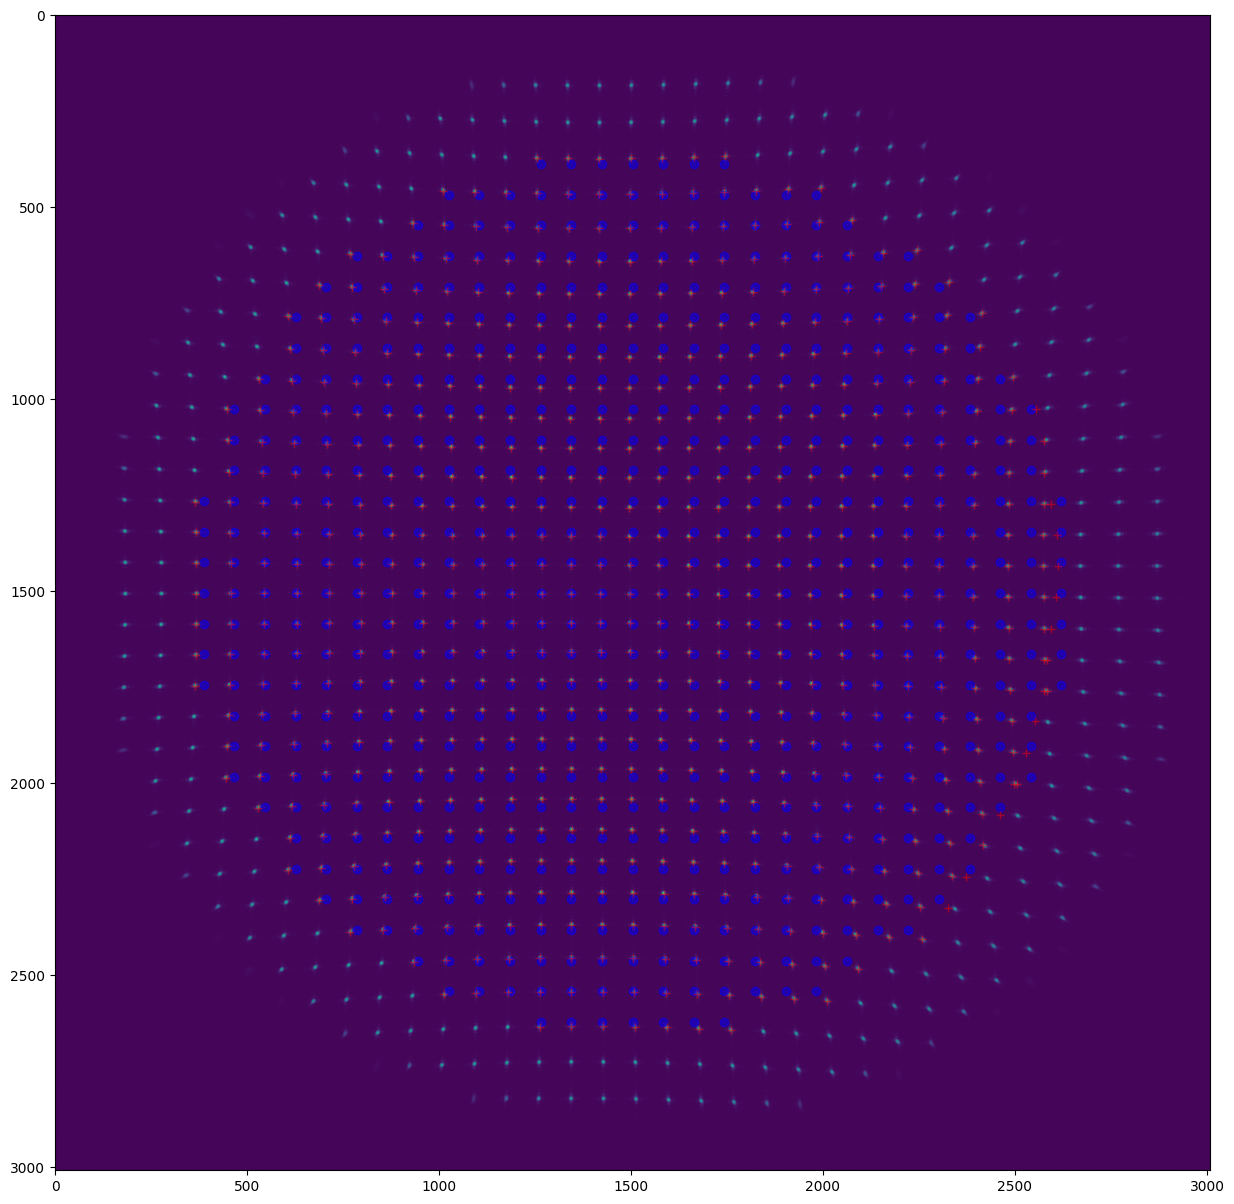

In [108]:

pitch_x = 0.3
pitch_y = 0.3

n_x = 33
n_y = 33

ulens_centres_x = np.linspace(-((pitch_x*(n_x-1))/2), ((pitch_x*(n_x-1))/2), n_x)
ulens_centres_y = np.linspace(-((pitch_y*(n_y-1))/2), ((pitch_y*(n_y-1))/2), n_y)

ulens_cell_corners = [[-0.5,0.5],[0.5,0.5],[0.5,-0.5],[-0.5,-0.5]]
micro_lens_positions_x, micro_lens_positions_y = np.meshgrid(ulens_centres_y, ulens_centres_x)



micro_lens_positions_x = micro_lens_positions_x.flatten()
micro_lens_positions_y = micro_lens_positions_y.flatten()

microlens_positions = []
for i in range(micro_lens_positions_x.size):
    microlens_positions.append((micro_lens_positions_x[i], micro_lens_positions_y[i]))



x_res = sh_capture.shape[0]
y_res = sh_capture.shape[1]
pixel_pitch_x = sensor_width  / x_res
pixel_pitch_y = sensor_height / y_res

ulens_aabb = []
for ulens in microlens_positions:
    lens_corners = np.empty(shape=(len(ulens_cell_corners),2))
    for cnr_idx in range(len(ulens_cell_corners)):
        cnr = ulens_cell_corners[cnr_idx]
        cnr_x = (cnr[0] * pitch_x) + ulens[0]
        cnr_y = (cnr[1] * pitch_y) + ulens[1]
        lens_corners[cnr_idx][0] = cnr_x
        lens_corners[cnr_idx][1] = cnr_y
    maxs = np.max(lens_corners, axis=0)     
    mins = np.min(lens_corners, axis=0)
    ulens_aabb.append([mins[0], mins[1], maxs[0], maxs[1], ulens[0], ulens[1]]) #min_x, min_y, max_x, max_y, centre x, centre y

cell_dbg_d = sh_capture
cell_infos = []
for ulens in ulens_aabb:
    min_cnr_pixels = np.array(optical_coords_to_pixel(ulens[0],ulens[3],pixel_pitch_x, pixel_pitch_y, x_res, y_res)).astype(int)
    max_cnr_pixels = np.array(optical_coords_to_pixel(ulens[2],ulens[1],pixel_pitch_x, pixel_pitch_y, x_res, y_res)).astype(int)
    cell = cell_dbg_d[min_cnr_pixels[1]:max_cnr_pixels[1], min_cnr_pixels[0]:max_cnr_pixels[0]]

    #temporary noise and constant offset
    cell = cell + np.random.normal(loc=0, scale=0.0001, size=cell.shape) + 0.05

    img_mean = np.mean(cell)
    img_max = np.max(cell)
    img_var = np.var(cell)

    max_to_mean = img_max - img_mean

    source_threshold = img_mean + max_to_mean * 0.1

    cell_thresholded = (cell > source_threshold)
    cell = cell_thresholded * cell
    #plt.imshow(cell)
    #plt.show()
    centroid_px = np.array(scipy.ndimage.center_of_mass(cell))
    centroid = (centroid_px-0.5) * pixel_pitch_x

    #need to flip y to go from pixel (Top left, pos down and right) to optical coords (0,0 centre)
    cell_size_y = ulens[3] - ulens[1]
    cell_size_x = ulens[2] - ulens[0]
    centroid[0] = cell_size_y - centroid[0]
    centroid[0] = centroid[0] - (cell_size_y/2)
    centroid[1] = centroid[1] - (cell_size_x/2)
    intensities = np.sort(cell, axis=None)[-8:]

    cell_info = {}
    cell_info["centroid_xy"] = np.array([centroid[1], centroid[0]])
    cell_info["lens_centre_xy"] = np.array([ulens[4],ulens[5]])
    cell_info["size_xy"] = np.array([ulens[2]-ulens[0], ulens[3]-ulens[1]])
    cell_info["intensities"] = np.sum(intensities)
    cell_infos.append(cell_info)


min_int = np.Infinity
max_int = 0
for c in cell_infos:
    if c['intensities'] < min_int:
        min_int = c['intensities']
    if c['intensities'] > max_int:
        max_int = c['intensities']


cell_int_thresh = ((max_int-min_int) * 0.05) + min_int
cells_for_calc = []
for c in cell_infos:
    cr, ct = coordinates.cart_to_polar(c["lens_centre_xy"][0],c["lens_centre_xy"][1] )
    if cr <= 4.3: #c['intensities'] > cell_int_thresh:
        cells_for_calc.append(c)


final_img = sh_capture
expected_pos_img_px = np.zeros((len(cells_for_calc),2))
deviation_img_px    = np.zeros((len(cells_for_calc),2))
for cell_idx in range(len(cells_for_calc)):
    c = cells_for_calc[cell_idx]

    expected_pos_image = c["lens_centre_xy"] 
    centroid_img = c["centroid_xy"] + c["lens_centre_xy"]
    expected_pos_img_px[cell_idx] = np.array(optical_coords_to_pixel(expected_pos_image[0],expected_pos_image[1],pixel_pitch_x, pixel_pitch_y, x_res, y_res))
    deviation_img_px[cell_idx]    = np.array(optical_coords_to_pixel(centroid_img[0],centroid_img[1],pixel_pitch_x, pixel_pitch_y, x_res, y_res))

plt.figure(figsize=(15,15))
plt.imshow(final_img)
plt.plot(expected_pos_img_px[:,0], expected_pos_img_px[:,1], marker ='o', color='blue', alpha=0.5,linestyle='None', zorder=4)
plt.plot(deviation_img_px[:,0], deviation_img_px[:,1], marker ='+', color='red', alpha=0.5, linestyle='None',zorder=6)
plt.show()



Fit for Z(1, 1) Tilt X: 0.00761174069294098
Fit for Z(1, -1) Tilt Y: 0.011324510298655673
Fit for Z(2, 0) Defocus: 0.0011262475082835543
Fit for Z(2, 2) Primary Astigmatism 00°: -0.009838886724739516
Fit for Z(2, -2) Primary Astigmatism 45°: 0.005865218165112029
Fit for Z(3, 1) Primary Coma X: -0.004382315933878657
Fit for Z(3, -1) Primary Coma Y: -0.0017273993295343875
Fit for Z(4, 0) Primary Spherical: -0.00804842565221716


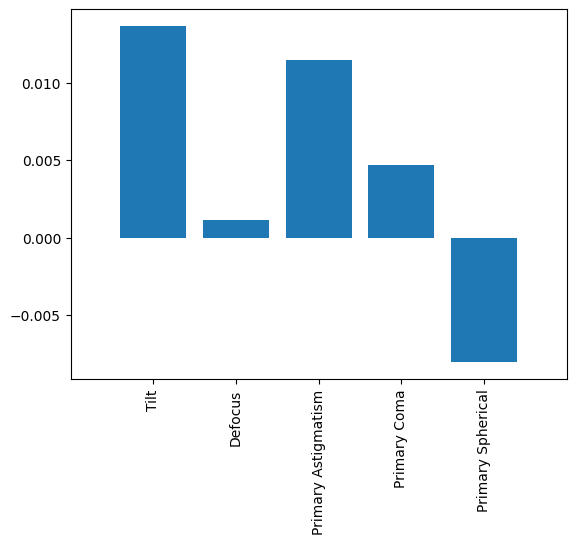

In [109]:
#now actually plot a wavefront

x = np.zeros((len(cells_for_calc)))
y = np.zeros((len(cells_for_calc)))
r = np.zeros((len(cells_for_calc)))
t = np.zeros((len(cells_for_calc)))
slopes_xy = np.zeros( (len(cells_for_calc),2))



normalisation_radius = 5

for cell_idx in range(len(cells_for_calc)):
    x[cell_idx] = cells_for_calc[cell_idx]["lens_centre_xy"][0]
    y[cell_idx] = cells_for_calc[cell_idx]["lens_centre_xy"][1]

    r[cell_idx], t[cell_idx] = coordinates.cart_to_polar(x[cell_idx], y[cell_idx])

    centroid_in_img = cells_for_calc[cell_idx]["centroid_xy"]  + cells_for_calc[cell_idx]["lens_centre_xy"]
    expected_in_img = cells_for_calc[cell_idx]["lens_centre_xy"]
    slopes_xy[cell_idx] = centroid_in_img - expected_in_img



slopes_xy = slopes_xy.T

dr, dt = cartesian_grad_to_polar_grad(x/normalisation_radius, y/normalisation_radius, slopes_xy[0], slopes_xy[1])

from prysm.polynomials import (
    fringe_to_nm,
    zernike_nm_der_sequence,
    zernike_nm_sequence,
    lstsq,
    sum_of_2d_modes,
    nm_to_name
)
from prysm.polynomials.zernike import barplot_magnitudes, zernikes_to_magnitude_angle

from prysm.util import rms


 #np.max(r)
r = r / normalisation_radius

fringe_indices = range(2,10)
nms = [fringe_to_nm(j) for j in fringe_indices]
zernike_strs = []
for nm in nms:
    zernike_strs.append(nm_to_name(nm[0], nm[1]))


modes = zernike_nm_der_sequence(nms, r, t)

fit = lstsq(modes, np.array([dr, dt]))
for f, zname, nm in zip(fit, zernike_strs, nms):
    print(f"Fit for Z{nm} {zname}: {f}")

pak = [[*nm, c] for nm, c in zip(nms, fit)]
magnitudes = zernikes_to_magnitude_angle(pak)
barplot_pak = {k: v[0] for k, v in magnitudes.items()}
barplot_magnitudes(barplot_pak)
plt.show()

